In [212]:
from __future__ import print_function
__author__ = "Sung Hoon Yang, CUSP NYU 2018"

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os
# puidata = os.getenv("PUIDATA")
# if puidata is None:
os.environ["PUIDATA"] = "%s/fall18/PUI/PUIDATA"% os.getenv("HOME")

%matplotlib inline
np.random.seed(999)

In [197]:
__RAW_DF__ = pd.read_csv(os.path.join(os.getenv('PUIDATA'), 'Open_Parking_and_Camera_Violations_100k.csv'))
__RAW_DF__.shape # (100000, 19)
__RAW_DF__.columns
"""
'Plate', 'State', 'License Type', 'Summons Number', 'Issue Date',
'Violation Time', 'Violation', 'Judgment Entry Date', 'Fine Amount',
'Penalty Amount', 'Interest Amount', 'Reduction Amount',
'Payment Amount', 'Amount Due', 'Precinct', 'County', 'Issuing Agency',
'Violation Status', 'Summons Image'
"""

"\n'Plate', 'State', 'License Type', 'Summons Number', 'Issue Date',\n'Violation Time', 'Violation', 'Judgment Entry Date', 'Fine Amount',\n'Penalty Amount', 'Interest Amount', 'Reduction Amount',\n'Payment Amount', 'Amount Due', 'Precinct', 'County', 'Issuing Agency',\n'Violation Status', 'Summons Image'\n"

In [198]:
"""
Display the top 7 rows of the DF in your notebook. This table must be rendered.
"""
__RAW_DF__.head(7)

,Plate,State,License Type,Summons Number,Issue Date,Violation Time,Violation,Judgment Entry Date,Fine Amount,Penalty Amount,Interest Amount,Reduction Amount,Payment Amount,Amount Due,Precinct,County,Issuing Agency,Violation Status,Summons Image
0,77160MC,NY,COM,8615815926,08/22/2018,03:31P,EXPIRED MUNI METER,NaN,65.0,0.0,0.0,0.0,0.0,65.0,7.0,NY,TRAFFIC,NaN,View Summons (http://nycserv.nyc.gov/NYCServWe...
1,23737TC,NY,TRC,8504877188,06/19/2017,02:00P,NO STANDING-DAY/TIME LIMITS,NaN,115.0,0.0,0.0,0.0,0.0,115.0,1.0,NY,TRAFFIC,HEARING HELD-GUILTY,View Summons (http://nycserv.nyc.gov/NYCServWe...
2,U10BME,NJ,PAS,4632348417,03/29/2017,10:48A,PHTO SCHOOL ZN SPEED VIOLATION,NaN,50.0,0.0,0.0,0.0,50.0,0.0,0.0,BX,DEPARTMENT OF TRANSPORTATION,NaN,View Summons (http://nycserv.nyc.gov/NYCServWe...
3,86585JU,NY,COM,8478933505,02/26/2018,03:10P,EXPIRED MUNI MTR-COMM MTR ZN,NaN,65.0,0.0,0.0,13.0,52.0,0.0,13.0,NY,TRAFFIC,HEARING HELD-GUILTY REDUCTION,View Summons (http://nycserv.nyc.gov/NYCServWe...
4,HGK5324,NY,PAS,8551494120,09/20/2017,08:21A,NO PARKING-DAY/TIME LIMITS,NaN,60.0,0.0,0.0,60.0,0.0,0.0,62.0,K,TRAFFIC,HEARING HELD-NOT GUILTY,View Summons (http://nycserv.nyc.gov/NYCServWe...
5,HUC7830,NY,PAS,8595971651,12/23/2017,12:22P,EXPIRED MUNI METER,NaN,35.0,10.0,0.0,0.0,45.0,0.0,107.0,Q,TRAFFIC,NaN,View Summons (http://nycserv.nyc.gov/NYCServWe...
6,066D42,MI,PAS,7766351341,06/16/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,View Summons (http://nycserv.nyc.gov/NYCServWe...


## I want to compare time of the day in minutes as the dependent variable, and find payment ('Payment Amount' + 'Amount Due')

#### starting data cleansing for time of the day in minutes. the column name will be violation_nth_min

In [199]:
from datetime import datetime
def get_time_in_mins(df):
    """
    1. there is cleansing to be done, because 12PM is written as such, but 12AM is written as 0AM
    2. some hours are incorrect e.g. 26AM?
    3. interpretation format should change 
    """
    d, s = df['Issue Date'], df['Violation Time']
    try:
        if s.startswith('00'):
            s = '12' + s[2:]
        if s.endswith('A') or s.endswith('P'):
            s += 'M'
            f = '%m/%d/%Y %I:%M%p'
        else:
            f = '%m/%d/%Y %H:%M'
        dt = datetime.strptime(d + ' ' + s, f)
        return dt.hour * 60 + dt.minute
    except ValueError as e:
        return None

# filter out rows whose Violation Time or Issue Date is NaN
tmp_df = __RAW_DF__[(~__RAW_DF__['Violation Time'].isnull()) & (~__RAW_DF__['Issue Date'].isnull())]
tmp_df['violation_nth_min'] = tmp_df.apply(get_time_in_mins, axis=1)
tmp_df = tmp_df[~tmp_df.violation_nth_min.isnull()]
raw_tmp_df = tmp_df
raw_tmp_df.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(93237, 20)

#### now make the total payment column. name will be total_fine

In [200]:
tmp_df['total_fine'] = tmp_df['Payment Amount'] + tmp_df['Amount Due']

In [201]:
"""
compare 'Violation Time' in nth minute in 1440 of a day with ('Payment Amount' + 'Amount Due')
"""
del_cols = ['Plate', 'State', 'License Type', 'Summons Number', 'Issue Date',
'Violation Time', 'Violation', 'Judgment Entry Date', 'Fine Amount',
'Penalty Amount', 'Interest Amount', 'Reduction Amount',
'Payment Amount', 'Amount Due', 'Precinct', 'County', 'Issuing Agency',
'Violation Status', 'Summons Image']
tmp_df.drop(inplace=True, axis=1, labels=del_cols)
"""
Display the reducted dataframe. This table must be rendered.
"""
tmp_df.head(7)

,violation_nth_min,total_fine
0,931.0,65.0
1,840.0,115.0
2,648.0,50.0
3,910.0,52.0
4,501.0,0.0
5,742.0,45.0
7,516.0,45.0


In [202]:
# let us remove the records whose total fine amounts to zero
tmp_df = tmp_df[tmp_df.total_fine > 0]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


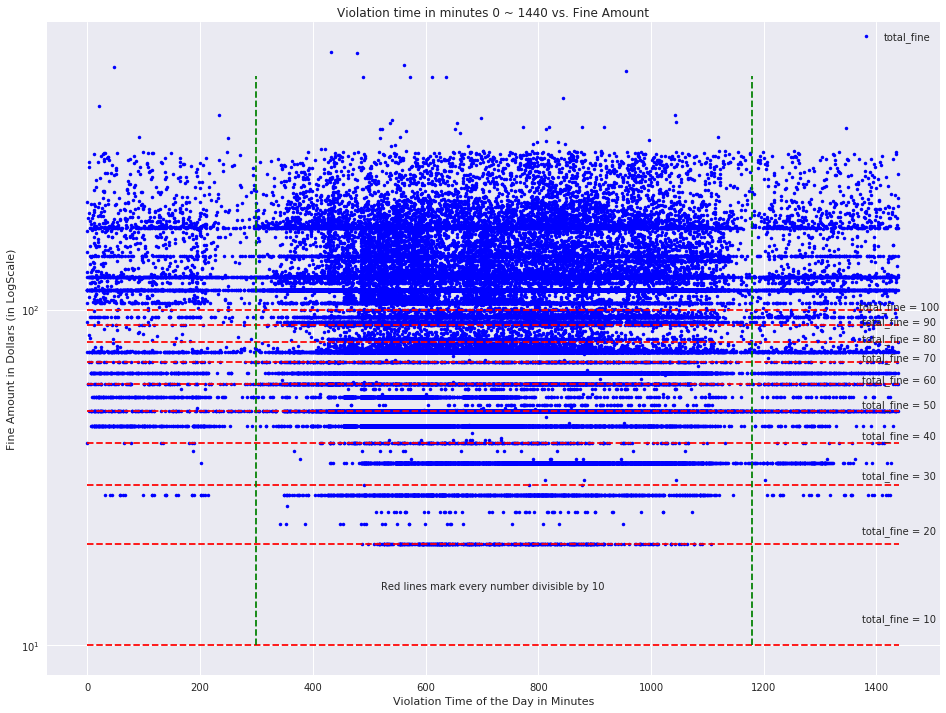

In [203]:
fig = plt.figure(figsize=(16,12))
kw = dict(
    xlabel='Violation Time of the Day in Minutes'
    , ylabel = 'Fine Amount in Dollars (in LogScale)'
    , yscale='log'
    , title = 'Violation time in minutes 0 ~ 1440 vs. Fine Amount'
)
ax = plt.gca(**kw)
ax.plot(tmp_df.violation_nth_min, tmp_df.total_fine, '.', c='blue', markeredgecolor='none')
ax.legend()

# strata marking with red dotted-lines
for i in range(1, 101):
    if i % 10 == 0:
        ax.plot([0, 1440], [i, i], 'r--')
        plt.annotate(
            "total_fine = %d" %i
            , xy=(0, 45)
            , xytext=(1440, i + 2)
            , xycoords='data'
            , textcoords='data'
            , horizontalalignment='center'
            , verticalalignment='center'
        )
plt.annotate(
    "Red lines mark every number divisible by 10"
    , xy=(0, 45)
    , xytext=(720, 15)
    , xycoords='data'
    , textcoords='data'
    , horizontalalignment='center'
    , verticalalignment='center'
)

# lax hours marked with green dotted-lines
ax.plot([300, 300], [10, 500], 'g--')
ax.plot([1180, 1180], [10, 500], 'g--')
plt.show()

#### Caption:
* Below < 100 USD, there is a clear formation of strata, as annotated for total_fine = 50 red dotted-line.
* The busiest hours for fining is from ~300th min (i.e. 5AM) to 1150~1200th min (i.e. 7~8PM)
* The gaps in daily fines are marked with green columns at above hours.

In [204]:
# flush
plt.clf()
plt.cla()
plt.close()

#### I will repeat the above, but this time, I will not convert time to # of minutes, but treat it as datetime

In [205]:
"""
you may notice that below is the copy-paste of above code...
"""
from datetime import datetime
def get_time_in_mins(df):
    """
    ! now the method returns datetime.datetime instead of int !
    
    1. there is cleansing to be done, because 12PM is written as such, but 12AM is written as 0AM
    2. some hours are incorrect e.g. 26AM?
    3. interpretation format should change 
    """
    d, s = df['Issue Date'], df['Violation Time']
    try:
        if s.startswith('00'):
            s = '12' + s[2:]
        if s.endswith('A') or s.endswith('P'):
            s += 'M'
            f = '%m/%d/%Y %I:%M%p'
        else:
            f = '%m/%d/%Y %H:%M'
        return datetime.strptime(d + ' ' + s, f)
    except ValueError as e:
        return None

# filter out rows whose Violation Time or Issue Date is NaN
tmp_df = __RAW_DF__[(~__RAW_DF__['Violation Time'].isnull()) & (~__RAW_DF__['Issue Date'].isnull())]
tmp_df['violation_dt'] = tmp_df.apply(get_time_in_mins, axis=1)
tmp_df = tmp_df[~tmp_df.violation_dt.isnull()]
tmp_df['total_fine'] = tmp_df['Payment Amount'] + tmp_df['Amount Due']
# Again, let us remove the records whose total fine amounts to zero
tmp_df = tmp_df[tmp_df.total_fine > 0]
# just looking at 2016~2018
tmp_df = tmp_df[('2015-12-31 23:59:59' < tmp_df.violation_dt) & (tmp_df.violation_dt < '2018-12-31 23:59:59')]
"""
drop columns that we won't look at
"""
del_cols = ['Plate', 'State', 'License Type', 'Summons Number', 'Issue Date',
'Violation Time', 'Violation', 'Judgment Entry Date', 'Fine Amount',
'Penalty Amount', 'Interest Amount', 'Reduction Amount',
'Payment Amount', 'Amount Due', 'Precinct', 'County', 'Issuing Agency',
'Violation Status', 'Summons Image']
tmp_df.drop(inplace=True, axis=1, labels=del_cols)
"""
Display the reducted dataframe. This table must be rendered.
"""
tmp_df.head(7)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,violation_dt,total_fine
0,2018-08-22 15:31:00,65.00
1,2017-06-19 14:00:00,115.00
2,2017-03-29 10:48:00,50.00
3,2018-02-26 15:10:00,52.00
5,2017-12-23 12:22:00,45.00
7,2016-06-02 08:36:00,45.00
8,2016-04-19 12:08:00,105.67


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


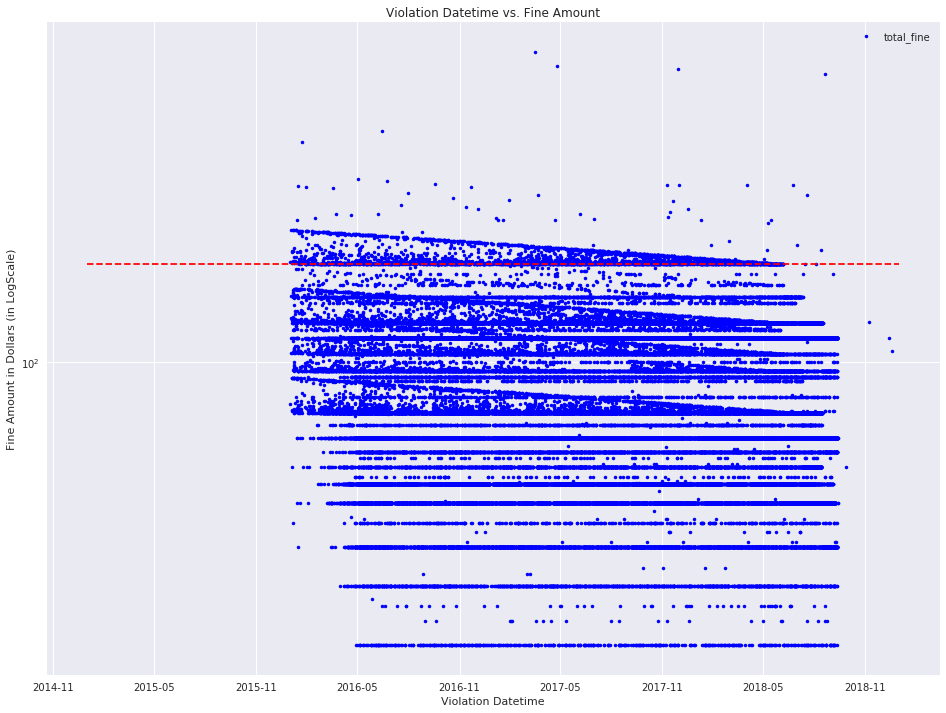

In [206]:
fig = plt.figure(figsize=(16,12))
kw = dict(
    xlabel='Violation Datetime'
    , ylabel = 'Fine Amount in Dollars (in LogScale)'
    , yscale='log'
    , title = 'Violation Datetime vs. Fine Amount'
)
ax = plt.gca(**kw)
ax.plot(tmp_df.violation_dt, tmp_df.total_fine, '.', c='blue', markeredgecolor='none')
ax.plot([datetime.strptime('2015-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2018-12-31 23:59:59', '%Y-%m-%d %H:%M:%S')], [175, 175], 'r--')
ax.legend()
plt.show()

#### CAPTION
* interval is ('2015-01-01 23:59:59', '2018-12-31 23:59:59')
* it's hard to know what the general trend is, because this is not an aggregate data
* there seems to be confluence of aforementioned strata, as you can see that red dotted-line, marking total_find = 175, is merging with the strata above it. 

In [207]:
# flush
plt.clf()
plt.cla()
plt.close()

#### Let us aggregate by date, and sum the total_fine for each event

In [208]:
tmp_df.set_index('violation_dt', inplace=True)
daily_sum = tmp_df.groupby(tmp_df.index.date).sum()
daily_sum.head(7)

,total_fine
2016-01-01,255.87
2016-01-02,495.60
2016-01-03,657.00
2016-01-04,1541.50
2016-01-05,1838.57
2016-01-06,1804.54
2016-01-07,3176.82


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


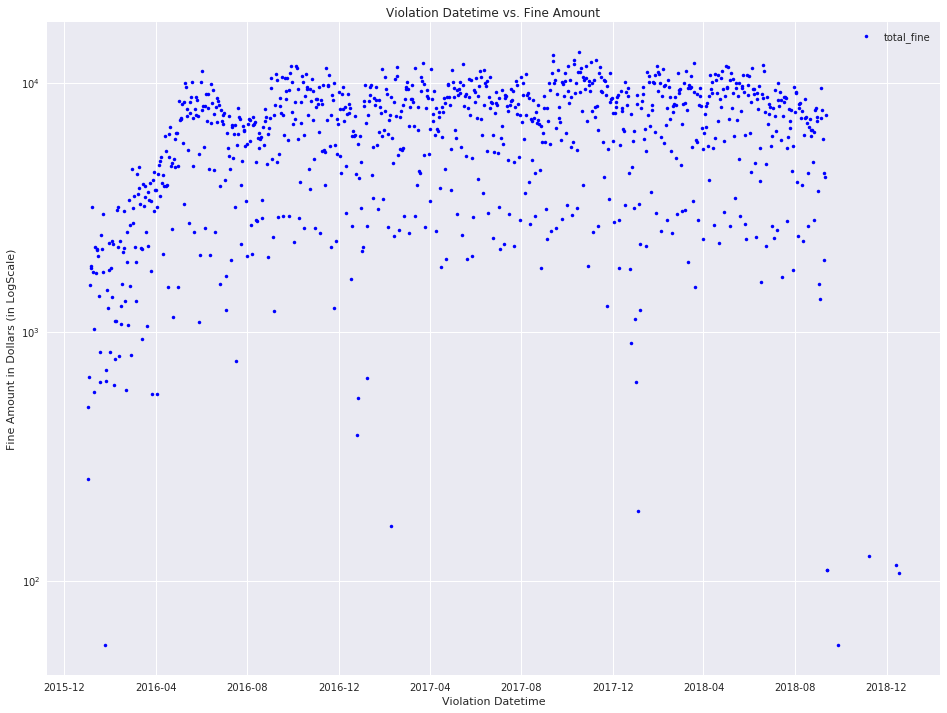

In [209]:
fig = plt.figure(figsize=(16,12))
kw = dict(
    xlabel='Violation Datetime'
    , ylabel = 'Fine Amount in Dollars (in LogScale)'
    , yscale='log'
    , title = 'Violation Datetime vs. Fine Amount'
)
ax = plt.gca(**kw)
ax.plot(daily_sum.index, daily_sum.total_fine, '.', c='blue', markeredgecolor='none')
# ax.plot([datetime.strptime('2015-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2018-12-31 23:59:59', '%Y-%m-%d %H:%M:%S')], [175, 175], 'r--')
ax.legend()
plt.show()

In [210]:
"""
Why is there an upward trend from dec. 2015 to apr. 2016?
"""
tmp_df[
    (tmp_df.index > datetime.strptime('2015-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')) &
    (tmp_df.index < datetime.strptime('2016-05-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
      ].count() # 2972
tmp_df[
    (tmp_df.index > datetime.strptime('2016-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')) &
    (tmp_df.index < datetime.strptime('2017-05-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
      ].count() # 12170
"""
Hypothesis: data that falls within dec. 2015 to apr. 2016 duration seems to be incomplete. 
There is simply too few records, only one-fourth compared to the same duration a year forward.
"""

'\nHypothesis: data that falls within dec. 2015 to apr. 2016 duration seems to be incomplete. \nThere is simply too few records, (only a fourth!) compared to the same duration a year forward.\n'

#### CAPTION
* upward trend from dec. 2015 to apr. 2016 seems to be due to the incompleteness of the data of the epoch
* Daily sum trend is at ~ 10000 USD and stays there more or less constantly

In [211]:
## end of NoteBook